In [34]:
# Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import matplotlib.pyplot as plt #visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns #visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler  # encode categorical variables 

# Import dataset 
telcom = pd.read_csv('Telco_customer_churn.csv')


# Basic information about dataset 
print ("Rows     : " ,telcom.shape[0])
print ("Columns  : " ,telcom.shape[1])
print ("\nFeatures : \n" ,telcom.columns.tolist())
print ("\nMissing values :  ", telcom.isnull().sum().values.sum())
print ("\nUnique values :  \n",telcom.nunique())
print("General Stats::", telcom.info())
print("Summary Stats::", telcom.describe())


('Rows     : ', 7043)
('Columns  : ', 21)
('\nFeatures : \n', ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'])
('\nMissing values :  ', 0)
('\nUnique values :  \n', customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64)
<class 'pandas.core.

(array([], dtype=int64), array([], dtype=int64))


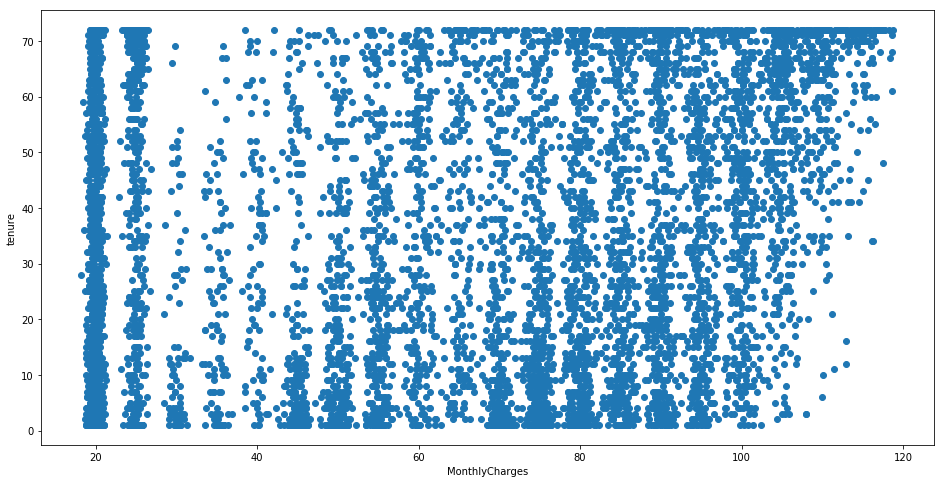

In [35]:
# 11 missing values for the Total charges column
telcom[telcom['TotalCharges']== " "]
#Replacing spaces with null values in total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan)
#Dropping null values from total charges column which contain.
telcom = telcom[telcom["TotalCharges"].notnull()]
telcom = telcom.reset_index()[telcom.columns]
#convert to float type
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)


#Replace 'No internet service' to 'No' for the following columns. If they don't have internet, they don't have access to these services. 
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    telcom[i]  = telcom[i].replace({'No internet service' : 'No'})

# Replace 'No phone service' to 'No' for the MultipleLines columns. 
telcom['MultipleLines'] = telcom['MultipleLines'].replace({'No phone service':'No'})

# Modify Senior Citizen binary dummy variable. Want Yes or No instead of 0,1. 
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})


#Add new variable: tenure to categorical column, sorted by year. Only for visualization purposes. 
def tenure_lab(telcom) :   
    if telcom["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (telcom["tenure"] > 12) & (telcom["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (telcom["tenure"] > 24) & (telcom["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (telcom["tenure"] > 48) & (telcom["tenure"] <= 60) :
        return "Tenure_48-60"
    elif telcom["tenure"] > 60 :
        return "Tenure_gt_60"
telcom["tenure_group"] = telcom.apply(lambda telcom:tenure_lab(telcom),
                                      axis = 1)

#Separating churn and non churn customers. 
churn     = telcom[telcom["Churn"] == "Yes"]
not_churn = telcom[telcom["Churn"] == "No"]

#Separating catagorical and numerical columns
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]
num_col = telcom[['tenure', 'MonthlyCharges', 'TotalCharges']]

# Separate binary variables from those with more than 2 categories
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()  # binary categorical variables
multi_cols = [i for i in cat_cols if i not in bin_cols]   # columns with more than 2 values
 

#Find and remove outliers: Z-Score method. 
from scipy import stats
z = np.abs(stats.zscore(num_col))
print(np.where(abs(z) > 3))
# There are no observation for continuous variables that constitutes an outlier as no Z-score is greater than 3 ro lower than -3. 

# Confirmation via graphical visualization of potential outlliers
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(telcom['MonthlyCharges'], telcom['tenure'])
ax.set_xlabel('MonthlyCharges')
ax.set_ylabel('tenure')
plt.show()

In [25]:


# Label churn variable
lab = telcom["Churn"].value_counts().keys().tolist()
# Values per label 
val = telcom["Churn"].value_counts().values.tolist()

# Plot churn/non churn proportion
trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'royalblue' ,'orange'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer attrition in data",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )
data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)


In [27]:

# Function for pie plot for customer attrition types
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)



# Function for histogram for customer attrition types
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)
    
    
# Function for scatter plot matrix for numerical columns in data
def scatter_matrix(df)  :
    
    df  = df.sort_values(by = "Churn" ,ascending = True)
    classes = df["Churn"].unique().tolist()
    classes
    
    class_code  = {classes[k] : k for k in range(2)}
    class_code

    color_vals = [class_code[cl] for cl in df["Churn"]]
    color_vals

    pl_colorscale = "Portland"

    pl_colorscale

    text = [df.loc[k,"Churn"] for k in range(len(df))]
    text

    trace = go.Splom(dimensions = [dict(label  = "tenure",
                                       values = df["tenure"]),
                                  dict(label  = 'MonthlyCharges',
                                       values = df['MonthlyCharges']),
                                  dict(label  = 'TotalCharges',
                                       values = df['TotalCharges'])],
                     text = text,
                     marker = dict(color = color_vals,
                                   colorscale = pl_colorscale,
                                   size = 3,
                                   showscale = False,
                                   line = dict(width = .1,
                                               color='rgb(230,230,230)'
                                              )
                                  )
                    )
    axis = dict(showline  = True,
                zeroline  = False,
                gridcolor = "#fff",
                ticklen   = 4
               )
    
    layout = go.Layout(dict(title  = 
                            "Scatter plot matrix for Numerical columns for customer attrition",
                            autosize = False,
                            height = 800,
                            width  = 800,
                            dragmode = "select",
                            hovermode = "closest",
                            plot_bgcolor  = 'rgba(240,240,240, 0.95)',
                            xaxis1 = dict(axis),
                            yaxis1 = dict(axis),
                            xaxis2 = dict(axis),
                            yaxis2 = dict(axis),
                            xaxis3 = dict(axis),
                            yaxis3 = dict(axis),
                           )
                      )
    data   = [trace]
    fig = go.Figure(data = data,layout = layout )
    py.iplot(fig)



In [6]:
# Plot pie for all categorical columns 
for i in cat_cols :
    plot_pie(i)


In [7]:
# Plot histgram for all numerical columns   
for i in num_cols :
    histogram(i)

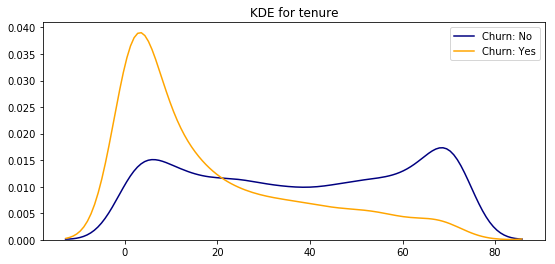

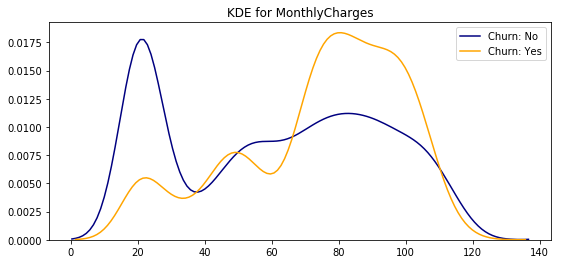

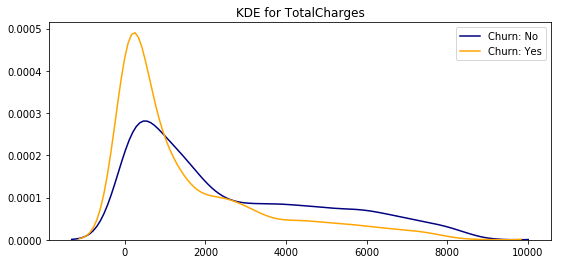

In [8]:
# Kernel density estimates of the 3 continuous features. (non parametric way to estimate the pdf of a Random Variable)
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(telcom[telcom['Churn'] == 'No'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(telcom[telcom['Churn'] == 'Yes'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

#scatter plot matrix
scatter_matrix(telcom)

In [9]:
# Customer attrition in tenure groups
tg_ch  =  churn["tenure_group"].value_counts().reset_index()
tg_ch.columns  = ["tenure_group","count"]
tg_nch =  not_churn["tenure_group"].value_counts().reset_index()
tg_nch.columns = ["tenure_group","count"]

# Bar - churn
trace1 = go.Bar(x = tg_ch["tenure_group"]  , y = tg_ch["count"],
                name = "Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

# Bar - not churn
trace2 = go.Bar(x = tg_nch["tenure_group"] , y = tg_nch["count"],
                name = "Non Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)


layout = go.Layout(dict(title = "Customer attrition in tenure groups",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "tenure group",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                       )
                  )
data = [trace1,trace2]
fig  = go.Figure(data=data,layout=layout)
py.iplot(fig)


In [28]:

# Scatter plot monthly charges & total charges by tenure group
def plot_tenure_scatter(tenure_group,color) :
    tracer = go.Scatter(x = telcom[telcom["tenure_group"] == tenure_group]["MonthlyCharges"],
                        y = telcom[telcom["tenure_group"] == tenure_group]["TotalCharges"],
                        mode = "markers",marker = dict(line = dict(color = "black",
                                                                   width = .2),
                                                       size = 4 , color = color,
                                                       symbol = "diamond-dot",
                                                      ),
                        name = tenure_group,
                        opacity = .9
                       )
    return tracer

# Scatter plot monthly charges & total charges by churn group
def plot_churncharges_scatter(churn,color) :
    tracer = go.Scatter(x = telcom[telcom["Churn"] == churn]["MonthlyCharges"],
                        y = telcom[telcom["Churn"] == churn]["TotalCharges"],
                        mode = "markers",marker = dict(line = dict(color = "black",
                                                                   width = .2),
                                                       size = 4 , color = color,
                                                       symbol = "diamond-dot",
                                                      ),
                        name = "Churn - " + churn,
                        opacity = .9
                       )
    return tracer

trace1 = plot_tenure_scatter("Tenure_0-12","#FF3300")
trace2 = plot_tenure_scatter("Tenure_12-24","#6666FF")
trace3 = plot_tenure_scatter("Tenure_24-48","#99FF00")
trace4 = plot_tenure_scatter("Tenure_48-60","#996600")
trace5 = plot_tenure_scatter("Tenure_gt_60","grey")
trace6 = plot_churncharges_scatter("Yes","red")
trace7 = plot_churncharges_scatter("No","blue")

data1   = [trace1,trace2,trace3,trace4,trace5] 
data2   = [trace7,trace6]



In [11]:
def layout_title(title) :
    layout = go.Layout(dict(title = title,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Monthly charges",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Total Charges",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            height = 600
                           )
                      )
    return layout

# Plots the 2 scatters mentionned above 
layout1  = layout_title("Monthly Charges & Total Charges by Tenure group")
layout2  = layout_title("Monthly Charges & Total Charges by Churn group")
fig1 = go.Figure(data = data1,layout = layout1)
fig2 = go.Figure(data = data2,layout = layout2)
py.iplot(fig1)
py.iplot(fig2)

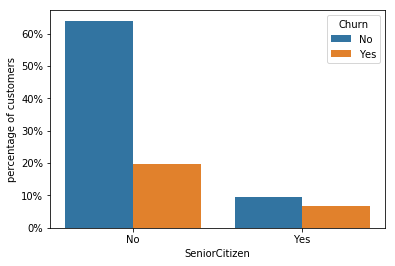

In [12]:
# Defintion function
def barplot_percentages(feature, orient='v', axis_name="percentage of customers"):
    ratios = pd.DataFrame()
    g = telcom.groupby(feature)["Churn"].value_counts().to_frame()
    g = g.rename({"Churn": axis_name}, axis=1).reset_index()
    g[axis_name] = g[axis_name]/len(telcom)
    if orient == 'v':
        ax = sns.barplot(x=feature, y= axis_name, hue='Churn', data=g, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x= axis_name, y=feature, hue='Churn', data=g, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.plot()
barplot_percentages("SeniorCitizen")

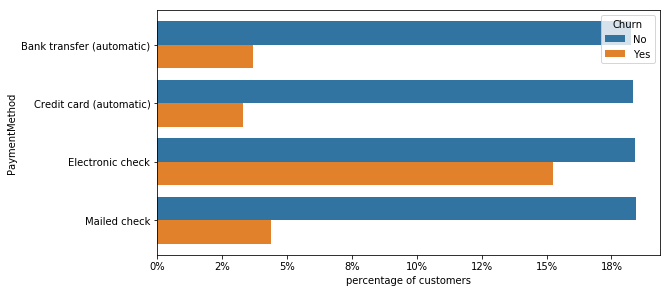

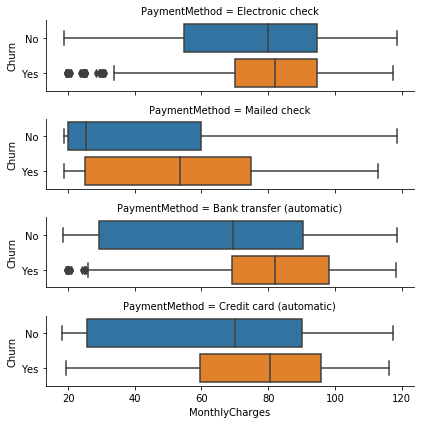

In [13]:
# Payement method 
plt.figure(figsize=(9, 4.5))
barplot_percentages("PaymentMethod", orient='h')
ax = sns.catplot(y="Churn", x="MonthlyCharges", row="PaymentMethod", kind="box", data=telcom, height=1.5, aspect=4, orient='h')


In [14]:
telcom['churn_rate'] = telcom['Churn'].replace("No", 0).replace("Yes", 1)

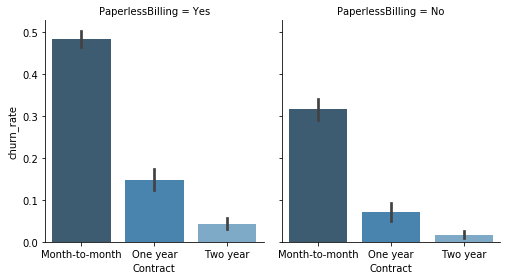

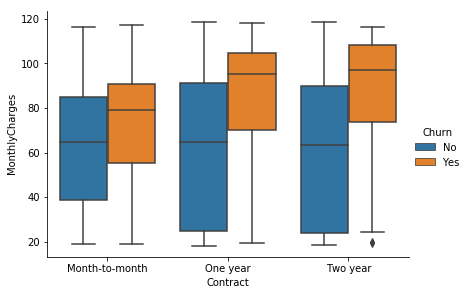

In [15]:
# Contract. Bias towards month-to-month contractors in churn category. 
g = sns.FacetGrid(telcom, col="PaperlessBilling", height=4, aspect=.9)
ax = g.map(sns.barplot, "Contract", "churn_rate", palette = "Blues_d", order= ['Month-to-month', 'One year', 'Two year'])
ax = sns.catplot(x="Contract", y="MonthlyCharges", hue="Churn", kind="box", data=telcom, height=4.2, aspect=1.4)


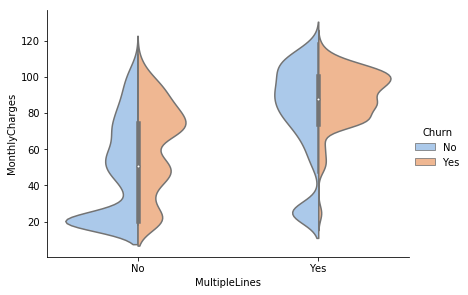

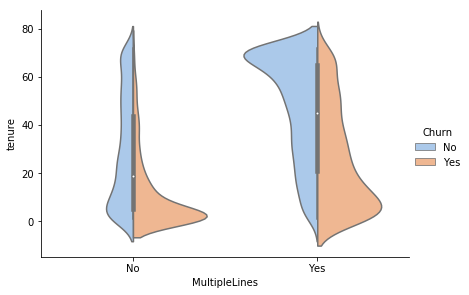

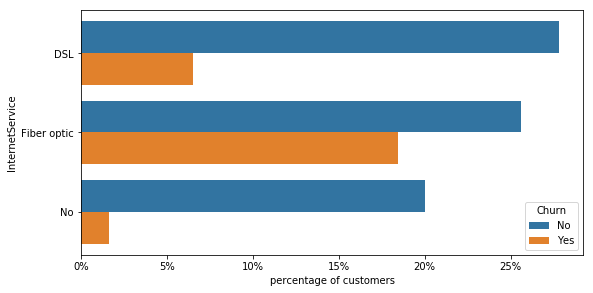

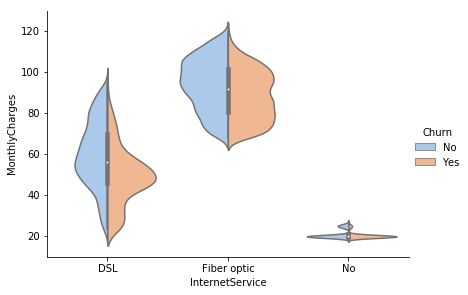

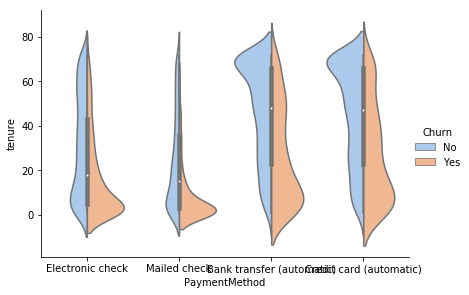

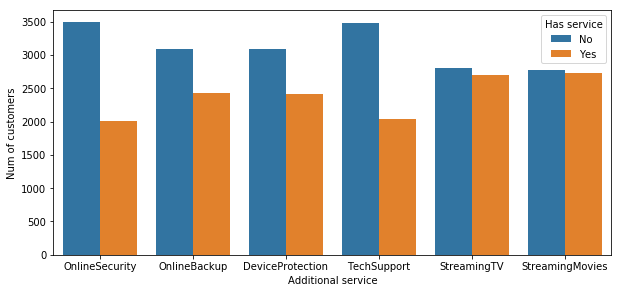

In [17]:
# Multiple phone lines and monthly charges 
ax = sns.catplot(x="MultipleLines", y="MonthlyCharges", hue="Churn", kind="violin",
                 split=True, palette="pastel", data=telcom, height=4.2, aspect=1.4)

# Multiple phone lines and tenure
ax = sns.catplot(x="MultipleLines", y="tenure", hue="Churn", kind="violin",
                 split=True, palette="pastel", data=telcom, height=4.2, aspect=1.4)

# Internet services
plt.figure(figsize=(9, 4.5))
barplot_percentages("InternetService", orient="h")

# Link with MontlyCharges
ax = sns.catplot(x="InternetService", y="MonthlyCharges", hue="Churn", kind="violin",
                 split=True, palette="pastel", data=telcom, height=4.2, aspect=1.4)

# Link with MontlyCharges
ax = sns.catplot(x="PaymentMethod", y="tenure", hue="Churn", kind="violin",
                 split=True, palette="pastel", data=telcom, height=4.2, aspect=1.4)

# Use of additional services 
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
df1 = pd.melt(telcom[telcom["InternetService"] != "No"][cols]).rename({'value': 'Has service'}, axis=1)
plt.figure(figsize=(10, 4.5))
ax = sns.countplot(data=df1, x='variable', hue='Has service')
ax.set(xlabel='Additional service', ylabel='Num of customers')
plt.show()

In [36]:
##### Feature engineering 


# Label encoding for Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
   
# Encode categorical variables
telcom = pd.get_dummies(data = telcom,columns = multi_cols )

#Scale Numerical variables
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

# Drop original values merging scaled values for numerical columns
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols,axis = 1)
telcom = telcom.merge(scaled,left_index=True,right_index=True,how = "left")


In [37]:

# Variable summary (in a table)
summary = (df_telcom_og[[i for i in df_telcom_og.columns if i not in Id_col]].
           describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#119DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Variable Summary"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)
 

In [38]:

###### Distribution of binary variables for both churn and non-churn customers 

# Separating binary columns
bi_cs = telcom.nunique()[telcom.nunique() == 2].keys()
dat_rad = telcom[bi_cs]

# Plot radar chart for churn and non churn customers(binary variables)
def plot_radar(df,aggregate,title) :
    data_frame = df[df["Churn"] == aggregate] 
    data_frame_x = data_frame[bi_cs].sum().reset_index()
    data_frame_x.columns  = ["feature","yes"]
    data_frame_x["no"]    = data_frame.shape[0]  - data_frame_x["yes"]
    data_frame_x  = data_frame_x[data_frame_x["feature"] != "Churn"]
    
    #count of 1's(yes)
    trace1 = go.Scatterpolar(r = data_frame_x["yes"].values.tolist(),
                             theta = data_frame_x["feature"].tolist(),
                             fill  = "toself",name = "count of 1's",
                             mode = "markers+lines",
                             marker = dict(size = 5)
                            )
    #count of 0's(No)
    trace2 = go.Scatterpolar(r = data_frame_x["no"].values.tolist(),
                             theta = data_frame_x["feature"].tolist(),
                             fill  = "toself",name = "count of 0's",
                             mode = "markers+lines",
                             marker = dict(size = 5)
                            ) 
    layout = go.Layout(dict(polar = dict(radialaxis = dict(visible = True,
                                                           side = "counterclockwise",
                                                           showline = True,
                                                           linewidth = 2,
                                                           tickwidth = 2,
                                                           gridcolor = "white",
                                                           gridwidth = 2),
                                         angularaxis = dict(tickfont = dict(size = 10),
                                                            layer = "below traces"
                                                           ),
                                         bgcolor  = "rgb(243,243,243)",
                                        ),
                            paper_bgcolor = "rgb(243,243,243)",
                            title = title,height = 700))
    
    data = [trace2,trace1]
    fig = go.Figure(data=data,layout=layout)
    py.iplot(fig)

# Plot
plot_radar(dat_rad,1,"Churn -  Customers")
plot_radar(dat_rad,0,"Non Churn - Customers")




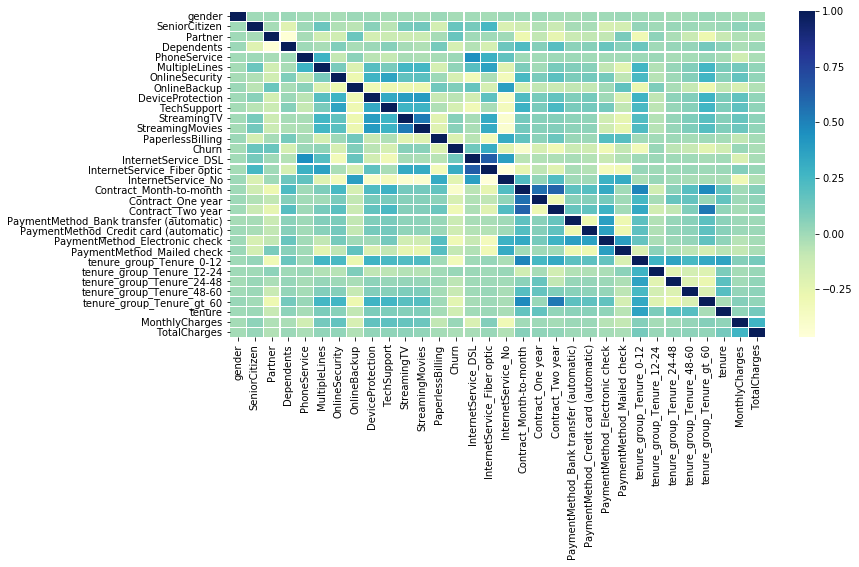

In [39]:
###### Correlation matrix 
plt.figure(figsize=(12, 6))
telcom.drop(['customerID'],axis=1, inplace=True)
corr = telcom.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")


# Correlation matrix 2.0 
correlation = telcom.corr()
matrix_cols = correlation.columns.tolist() #tick labels
corr_array  = np.array(correlation) #convert to array

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

